In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recentdate)

('2017-08-23',)


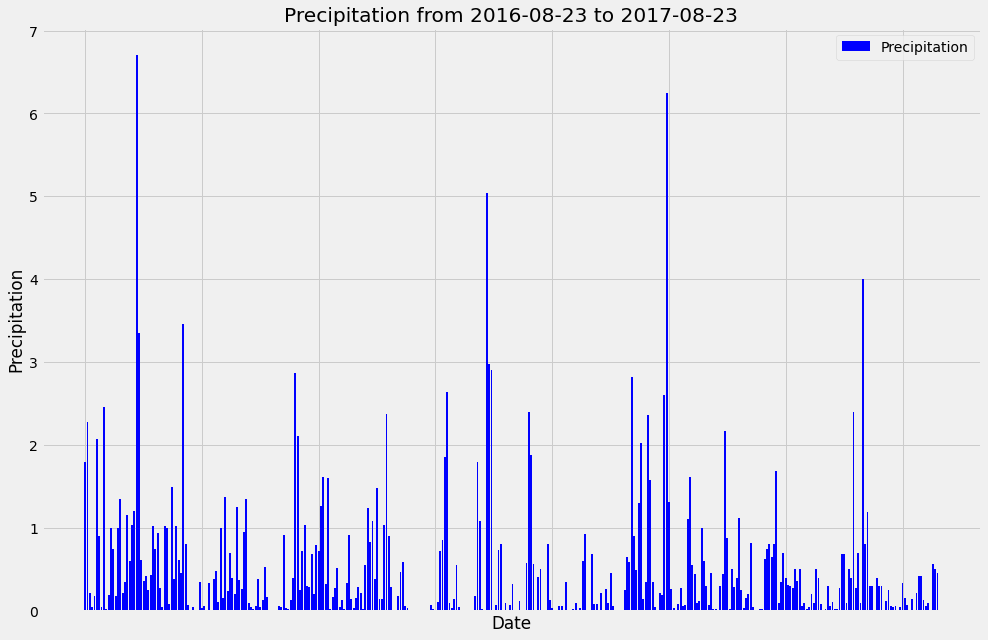

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
mostrecent = dt.datetime.strptime(recentdate[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
lastdate = dt.date(mostrecent.year -1, mostrecent.month, mostrecent.day)
lastdate

# Perform a query to retrieve the data and precipitation scores
query = [Measurement.date, Measurement.prcp]
result = session.query(*query).filter(Measurement.date >= lastdate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(result, columns=["Date", "Precipitation"])
precip = precip.dropna(how='any')
precip = precip.set_index("Date")\

# Sort the dataframe by date
precip = precip.sort_values(["Date"], ascending=True)
precip.head()

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precip.index.tolist()
y_axis = precip["Precipitation"].tolist()
plt.figure(figsize=(15,10))
plt.bar(x_axis, y_axis, color="blue", align="center", label="Precipitation")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
major_ticks = np.arange(0,400,50)
plt.xticks(major_ticks)
plt.title(f"Precipitation from {lastdate} to {recentdate[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
select = [Measurement.station,func.count(Measurement.id)]
stations = session.query(*select).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
select = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active = session.query(*select).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
most_active

(54.0, 85.0, 71.66378066378067)

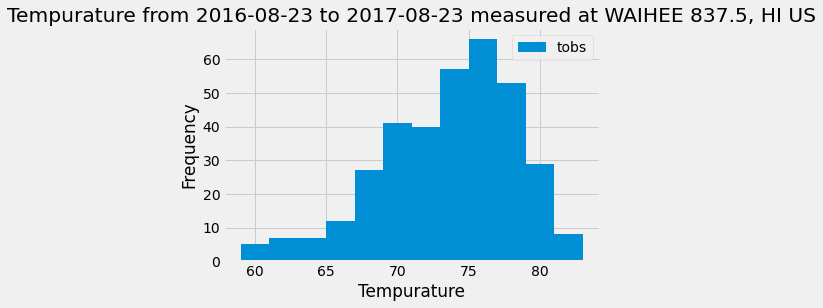

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.tobs).filter(Measurement.station == stations[0][0]).filter(Measurement.date >= lastdate).all()
temps = list(np.ravel(query))

select = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
result = session.query(*select).all()
station_df = pd.DataFrame(result, columns=["Station", "Name", "Latitude", "Longitude", "Elevation"])

station_name = station_df.loc[station_df["Station"] == stations[0][0], "Name"].tolist()[0]

plt.hist(temps, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.xlabel("Tempurature")
plt.title(f"Tempurature from {lastdate} to {recentdate[0]} measured at {station_name}")
plt.legend()
plt.show()

# Close session

In [16]:
# Close Session
session.close()